In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, T5Tokenizer, T5EncoderModel
import torch
import re
import json
import numpy as np
import sys

## Negative Samples Creation w/ Embeddings and Coisne Similarity

Here we chose the approach to create embeddings from the prot_t5_xl model and then check if the embedding is in a certain "un-similarity range" which is a self-defined threshold. This becuase evaluations showed that this is (at least as far as we consider) the "best" approach.

In [2]:
read_path_beta = "../data/customDatasets/Stitchr_paired_concatenated.tsv"
stitchr_paired_df = pd.read_csv(read_path_beta, sep="\t")

In [3]:
stitchr_paired_df

,TCR_name,TRA_nt,TRB_nt,TRA_aa,TRB_aa,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,...,TRB_3_prime_seq,Linked_nt,Linked_aa,Warnings/Errors,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,ATGAGGCTGGTGGCAAGAGTAACTGTGTTTCTGACCTTTGGAACTA...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MRLVARVTVFLTFGTIIDAKTTQPPSMDCAEGRAANLPCNHSTISG...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
1,2,ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MEKMLECAFIVLWLQLGWLSGEDQVTQSPEALRLQEGESSSLNCSY...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
2,4,ATGGCATGCCCTGGCTTCCTGTGGGCACTTGTGATCTCCACCTGTC...,ATGGTTTCCAGGCTTCTCAGTTTAGTGTCCCTTTGTCTCCTGGGAG...,MACPGFLWALVISTCLEFSMAQTVTQSQPEMSVQEAETVTLSCTYD...,MVSRLLSLVSLCLLGAKHIEAGVTQFPSHSVIEKGQTVTLRCDPIS...,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,...,NaN,NaN,NaN,[None],NaN,NaN,NaN,NaN,NaN,NaN
3,5,ATGAGGCTGGTGGCAAGAGTAACTGTGTTTCTGACCTTTGGAACTA...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MRLVARVTVFLTFGTIIDAKTTQPPSMDCAEGRAANLPCNHSTISG...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
4,6,ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MEKMLECAFIVLWLQLGWLSGEDQVTQSPEALRLQEGESSSLNCSY...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEQGGL,2.0,HLA-B*08,B2M,MHCI,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27826,29873,ATGAAGCCCACCCTCATCTCAGTGCTTGTGATAATATTTATACTCA...,ATGGGTCCTGGGCTTCTCCACTGGATGGCCCTTTGTCTCCTTGGAA...,MKPTLISVLVIIFILRGTRAQRVTQPEKLLSVFKGAPVELKCNYSY...,MGPGLLHWMALCLLGTGHGDAMVIQNPRYQVTQFGKPVTLSCSQTL...,TRAV16*01,TRAJ37*01,CALDGPSNTGKLIF,TRBV15*01,TRBJ2-2*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,LLWNGPMAV,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,1.0
27827,29874,ATGGAAACTCTCCTGGGAGTGTCTTTGGTGATTCTATGGCTTCAAC...,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,METLLGVSLVILWLQLARVNSQQGEEDPQALSIQEGENATMNCSYK...,MSNQVLCCVVLCFLGANTVDGGITQSPKYLFRKEGQNVTLSCEQNL...,TRAV17*01,TRAJ7*01,CATDAEGNNRLAF,TRBV19*01,TRBJ2-7*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,LLWNGPMAV,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,1.0
27828,29875,ATGGAGACTGTTCTGCAAGTACTCCTAGGGATATTGGGGTTCCAAG...,ATGGATACCTGGCTCGTATGCTGGGCAATTTTTAGTCTCTTGAAAG...,METVLQVLLGILGFQAAWVSSQELEQSPQSLIVQEGKNLTINCTSS...,MDTWLVCWAIFSLLKAGLTEPEVTQTPSHQVTQMGQEVILRCVPIS...,TRAV34*01,TRAJ13*01,CGAVGYQKVTF,TRBV2*01,TRBJ2-2*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,LLWNGPMAV,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,1.0
27829,29876,ATGCTCCTGTTGCTCATACCAGTGCTGGGGATGATTTTTGCCCTGA...,ATGGGCTGCAGGCTGCTCTGCTGTGCGGTTCTCTGTCTCCTGGGAG...,MLLLLIPVLGMIFALRDARAQSVSQHNHHVILSEAASLELGCNYSY...,MGCRLLCCAVLCLLGAVPMETGVTQTPRHLVMGMTNKKSLKCEQHL...,TRAV8-1*01,TRAJ43*01,CAVIWYNNNDMRF,TRBV4-2*01,TRBJ2-1*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,LLWNGPMAV,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,1.0


In [4]:
len(set(stitchr_paired_df["Epitope"]))

891

          Epitope  count
0       KLGGALQAK  13619
1       GILGFVFTL   1915
2      AVFDRKSDAK   1719
3        RAKFKQLL   1212
4             nan    761
..            ...    ...
886  RLPAKAPLLGCG      1
887      RLPAKAPL      1
888     FLGRYMSAL      1
889     GLNDNLLEI      1
890     FSASTSAFV      1

[891 rows x 2 columns]


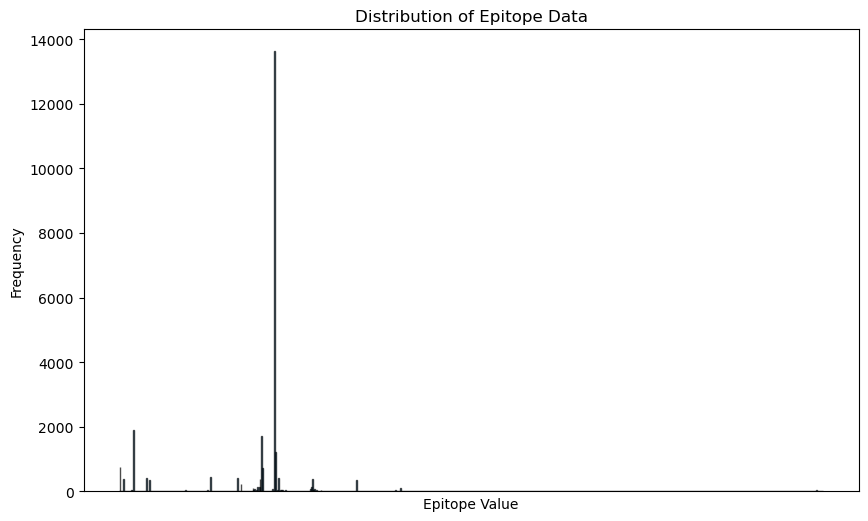

In [5]:
stitchr_paired_df['Epitope'] = stitchr_paired_df['Epitope'].astype(str)
epitope_counts = stitchr_paired_df['Epitope'].value_counts().reset_index()
print(epitope_counts)
epitope_counts.columns = ['Epitope Name', 'Count'] 

plt.figure(figsize=(10, 6))
plt.hist(stitchr_paired_df['Epitope'], bins=len(epitope_counts), edgecolor='k', alpha=0.7)
plt.xlabel('Epitope Value')
plt.ylabel('Frequency')
plt.title('Distribution of Epitope Data')
plt.xticks([])  # removes the x-axis labels
plt.show()

In [6]:
# print(epitope_counts.to_string())

In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))


Using device: cpu


In [8]:

#@title Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50 in half-precision)
transformer_link = "Rostlab/prot_t5_xl_half_uniref50-enc"
print("Loading: {}".format(transformer_link))
model = T5EncoderModel.from_pretrained(transformer_link)
if device==torch.device("cpu"):
  print("Casting model to full precision for running on CPU ...")
  model.to(torch.float32) # only cast to full-precision if no GPU is available
model = model.to(device)
model = model.eval()
tokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False, legacy=True)


Loading: Rostlab/prot_t5_xl_half_uniref50-enc
Casting model to full precision for running on CPU ...


In [9]:
epitopes = set(stitchr_paired_df["Epitope"].to_list())

In [10]:
# this will replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
processed_epitopes = [(sequence, " ".join(list(re.sub(r"[UZOB]", "X", sequence)))) for sequence in epitopes]
# processed_epitopes

In [11]:
def process_batch(processed_seqs):
    # Extract just the processed sequences for tokenization
    sequences = [seq[1] for seq in processed_seqs]
    ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest", return_tensors="pt")
    input_ids = ids['input_ids'].to(device)
    attention_mask = ids['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    last_hidden_states = outputs.last_hidden_state
    
    # Now, return embeddings mapped to the original sequence
    embeddings = {}
    for i, (original_seq, _) in enumerate(processed_seqs):
        seq_len = attention_mask[i].sum().item() - 2  # Subtract [CLS] and [SEP]
        valid_embeddings = last_hidden_states[i, 1:seq_len+1]
        mean_embedding = valid_embeddings.mean(dim=0)
        embeddings[original_seq] = mean_embedding.cpu().numpy()  # Use original sequence as key
    
    return embeddings

In [12]:
to_path = "../data/customDatasets/negative_samples/temp"
file_name = "Stitchr_paired_concatenated_with_epitope_embedding.tsv"

In [13]:

batch_size = 128
sequence_to_embedding = {}

# Batch processing with a dictionary, using original sequences as keys
for i in range(0, len(processed_epitopes), batch_size):
    batch_sequences = processed_epitopes[i:i+batch_size]
    batch_embeddings = process_batch(batch_sequences)
    sequence_to_embedding.update(batch_embeddings)

    stitchr_paired_df["Epitope Embedding"] = stitchr_paired_df["Epitope"].map(sequence_to_embedding)

# This is needed becuase the embedding is huge and otherwise it would be stored with line breaks (\n) 
# This would make it difficult while reading the file
stitchr_paired_df['Epitope Embedding'] = stitchr_paired_df['Epitope Embedding'].apply(lambda x: json.dumps(x.tolist()))

stitchr_paired_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)



The cell above is commented out to safe time. After changing something in the underlaying dataset re-run this cell to create the up-to-date embeddings!

In [14]:

stitchr_paired_df = pd.read_csv(to_path+"/"+file_name, sep="\t")
stitchr_paired_df['Epitope Embedding'] = stitchr_paired_df['Epitope Embedding'].apply(lambda x: np.array(json.loads(x)))

In [15]:
max_index = len(stitchr_paired_df) - 1 
negative_epitopes_cosine = []

In [16]:
def cosine_similarity(embedding1, embedding2): 
    cosine = np.dot(embedding1,embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    return cosine

In [17]:
def is_valid_negative(cosine_similarity, current_epitope, random_epitope): 
    is_valid = False
    cosine_min = -0.75
    cosine_max = 0.75

    if (cosine_similarity >= cosine_min \
        and cosine_similarity <= cosine_max) \
        and (current_epitope != random_epitope): 
        is_valid = True 

    return is_valid


In [18]:
sys_max_depth = sys.getrecursionlimit()
max_attempts_by_system = sys_max_depth - 1

In [19]:
len(stitchr_paired_df["Epitope"])

27831

In [20]:
def search_negative_epitope_embedding(df, index, current_epitope, max_attempts=max_attempts_by_system):
    current_embedding = df["Epitope Embedding"][index]
    attempt = 0
    
    while attempt < max_attempts:
        random_epitope_index = np.random.randint(0, len(df))
        random_epitope = df["Epitope"][random_epitope_index]
        
        if random_epitope_index == index:
            attempt += 1
            continue  # Skip the rest of the loop and try again
        
        random_epitope_embedding = df["Epitope Embedding"][random_epitope_index]
        cosine = cosine_similarity(current_embedding, random_epitope_embedding)
        
        if is_valid_negative(cosine, current_epitope, random_epitope) or attempt == max_attempts - 1:
            return random_epitope  # Return the found valid or last attempt epitope
        
        attempt += 1
    
    # This point should theoretically never be reached because of the check in the loop,
    # but it's a fallback to return a random different epitope if for some reason it does.
    while True:
        random_epitope_index = np.random.randint(0, len(df))
        if random_epitope_index != index:
            return df["Epitope"][random_epitope_index]

for i, epitope in enumerate(stitchr_paired_df["Epitope"]):
    negative_epitope = search_negative_epitope_embedding(stitchr_paired_df, i, epitope)
    negative_epitopes_cosine.append(negative_epitope)


In [21]:
len((negative_epitopes_cosine))

27831

In [22]:
negative_epitopes_cosine_dict = {"Negative Epitope": negative_epitopes_cosine}
negative_epitopes_cosine_df = pd.DataFrame(negative_epitopes_cosine_dict)
# print(negative_epitopes_cosine_df.to_string())
negative_epitopes_cosine_df

,Negative Epitope
0,LQPLALEGSLQKRG
1,GIIAMSAFA
2,NaN
3,YLQPRTFLL
4,ELAGIGILTV
...,...
27826,GILGFVFTL
27827,CINGVCWTV
27828,AVFDRKSDAK
27829,GILGFVFTL


    Epitope Name  Count
0      GILGFVFTL   6147
1      KLGGALQAK   3789
2     ELAGIGILTV   1553
3      GLCTLVAML   1423
4      SPRWYFYYL   1370
..           ...    ...
701    NLLKDCPAV      1
702    YTDFATSAC      1
703    AIMTRCLAV      1
704    CVMYASAVV      1
705    WLTYTGAIK      1

[706 rows x 2 columns]


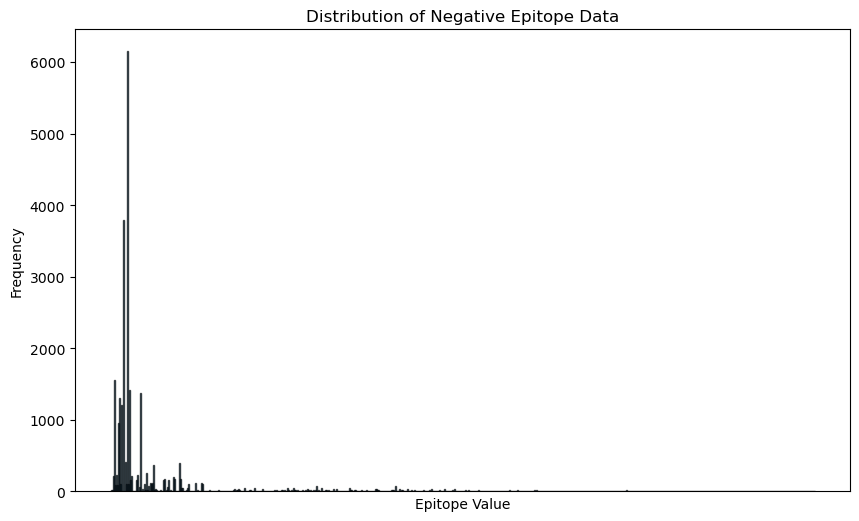

In [23]:
epitope_counts_negative = negative_epitopes_cosine_df['Negative Epitope'].value_counts().reset_index()
epitope_counts_negative.columns = ['Epitope Name', 'Count']
print(epitope_counts_negative) 

plt.figure(figsize=(10, 6))
plt.hist(negative_epitopes_cosine_df['Negative Epitope'].astype(str), bins=len(epitope_counts_negative), edgecolor='k', alpha=0.7)
plt.xlabel('Epitope Value')
plt.ylabel('Frequency')
plt.title('Distribution of Negative Epitope Data')
plt.xticks([])  # removes the x-axis labels
plt.show()

In [24]:
stitchr_paired_df.columns

Index(['TCR_name', 'TRA_nt', 'TRB_nt', 'TRA_aa', 'TRB_aa', 'TRAV', 'TRAJ',
       'TRA_CDR3', 'TRBV', 'TRBJ', 'TRB_CDR3', 'TRAC', 'TRBC', 'TRA_leader',
       'TRB_leader', 'Linker', 'Link_order', 'TRA_5_prime_seq',
       'TRA_3_prime_seq', 'TRB_5_prime_seq', 'TRB_3_prime_seq', 'Linked_nt',
       'Linked_aa', 'Warnings/Errors', 'Epitope', 'Score', 'MHC A', 'MHC B',
       'MHC class', 'Binding', 'Epitope Embedding'],
      dtype='object')

In [25]:
stitchr_paired_with_negative_df = stitchr_paired_df.drop(["Epitope Embedding"], axis=1).copy(deep=True)
stitchr_paired_with_negative_df["Binding"] = 0
stitchr_paired_with_negative_df["Epitope"] = negative_epitopes_cosine
stitchr_paired_with_negative_df

,TCR_name,TRA_nt,TRB_nt,TRA_aa,TRB_aa,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,...,TRB_3_prime_seq,Linked_nt,Linked_aa,Warnings/Errors,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,ATGAGGCTGGTGGCAAGAGTAACTGTGTTTCTGACCTTTGGAACTA...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MRLVARVTVFLTFGTIIDAKTTQPPSMDCAEGRAANLPCNHSTISG...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],LQPLALEGSLQKRG,2.0,HLA-B*08,B2M,MHCI,0
1,2,ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MEKMLECAFIVLWLQLGWLSGEDQVTQSPEALRLQEGESSSLNCSY...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],GIIAMSAFA,2.0,HLA-B*08,B2M,MHCI,0
2,4,ATGGCATGCCCTGGCTTCCTGTGGGCACTTGTGATCTCCACCTGTC...,ATGGTTTCCAGGCTTCTCAGTTTAGTGTCCCTTTGTCTCCTGGGAG...,MACPGFLWALVISTCLEFSMAQTVTQSQPEMSVQEAETVTLSCTYD...,MVSRLLSLVSLCLLGAKHIEAGVTQFPSHSVIEKGQTVTLRCDPIS...,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,...,NaN,NaN,NaN,[None],NaN,NaN,NaN,NaN,NaN,0
3,5,ATGAGGCTGGTGGCAAGAGTAACTGTGTTTCTGACCTTTGGAACTA...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MRLVARVTVFLTFGTIIDAKTTQPPSMDCAEGRAANLPCNHSTISG...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],YLQPRTFLL,2.0,HLA-B*08,B2M,MHCI,0
4,6,ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MEKMLECAFIVLWLQLGWLSGEDQVTQSPEALRLQEGESSSLNCSY...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],ELAGIGILTV,2.0,HLA-B*08,B2M,MHCI,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27826,29873,ATGAAGCCCACCCTCATCTCAGTGCTTGTGATAATATTTATACTCA...,ATGGGTCCTGGGCTTCTCCACTGGATGGCCCTTTGTCTCCTTGGAA...,MKPTLISVLVIIFILRGTRAQRVTQPEKLLSVFKGAPVELKCNYSY...,MGPGLLHWMALCLLGTGHGDAMVIQNPRYQVTQFGKPVTLSCSQTL...,TRAV16*01,TRAJ37*01,CALDGPSNTGKLIF,TRBV15*01,TRBJ2-2*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,GILGFVFTL,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,0
27827,29874,ATGGAAACTCTCCTGGGAGTGTCTTTGGTGATTCTATGGCTTCAAC...,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,METLLGVSLVILWLQLARVNSQQGEEDPQALSIQEGENATMNCSYK...,MSNQVLCCVVLCFLGANTVDGGITQSPKYLFRKEGQNVTLSCEQNL...,TRAV17*01,TRAJ7*01,CATDAEGNNRLAF,TRBV19*01,TRBJ2-7*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,CINGVCWTV,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,0
27828,29875,ATGGAGACTGTTCTGCAAGTACTCCTAGGGATATTGGGGTTCCAAG...,ATGGATACCTGGCTCGTATGCTGGGCAATTTTTAGTCTCTTGAAAG...,METVLQVLLGILGFQAAWVSSQELEQSPQSLIVQEGKNLTINCTSS...,MDTWLVCWAIFSLLKAGLTEPEVTQTPSHQVTQMGQEVILRCVPIS...,TRAV34*01,TRAJ13*01,CGAVGYQKVTF,TRBV2*01,TRBJ2-2*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,AVFDRKSDAK,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,0
27829,29876,ATGCTCCTGTTGCTCATACCAGTGCTGGGGATGATTTTTGCCCTGA...,ATGGGCTGCAGGCTGCTCTGCTGTGCGGTTCTCTGTCTCCTGGGAG...,MLLLLIPVLGMIFALRDARAQSVSQHNHHVILSEAASLELGCNYSY...,MGCRLLCCAVLCLLGAVPMETGVTQTPRHLVMGMTNKKSLKCEQHL...,TRAV8-1*01,TRAJ43*01,CAVIWYNNNDMRF,TRBV4-2*01,TRBJ2-1*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,GILGFVFTL,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,0


In [26]:
stitchr_paired_with_negative_df = pd.concat([stitchr_paired_df.drop(["Epitope Embedding"], axis=1).copy(deep=True), stitchr_paired_with_negative_df], axis=0)
stitchr_paired_with_negative_df["TCR_name"] = range(1, len(stitchr_paired_with_negative_df)+1)
stitchr_paired_with_negative_df

,TCR_name,TRA_nt,TRB_nt,TRA_aa,TRB_aa,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,...,TRB_3_prime_seq,Linked_nt,Linked_aa,Warnings/Errors,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,ATGAGGCTGGTGGCAAGAGTAACTGTGTTTCTGACCTTTGGAACTA...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MRLVARVTVFLTFGTIIDAKTTQPPSMDCAEGRAANLPCNHSTISG...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
1,2,ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MEKMLECAFIVLWLQLGWLSGEDQVTQSPEALRLQEGESSSLNCSY...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
2,3,ATGGCATGCCCTGGCTTCCTGTGGGCACTTGTGATCTCCACCTGTC...,ATGGTTTCCAGGCTTCTCAGTTTAGTGTCCCTTTGTCTCCTGGGAG...,MACPGFLWALVISTCLEFSMAQTVTQSQPEMSVQEAETVTLSCTYD...,MVSRLLSLVSLCLLGAKHIEAGVTQFPSHSVIEKGQTVTLRCDPIS...,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,...,NaN,NaN,NaN,[None],NaN,NaN,NaN,NaN,NaN,NaN
3,4,ATGAGGCTGGTGGCAAGAGTAACTGTGTTTCTGACCTTTGGAACTA...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MRLVARVTVFLTFGTIIDAKTTQPPSMDCAEGRAANLPCNHSTISG...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
4,5,ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MEKMLECAFIVLWLQLGWLSGEDQVTQSPEALRLQEGESSSLNCSY...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEQGGL,2.0,HLA-B*08,B2M,MHCI,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27826,55658,ATGAAGCCCACCCTCATCTCAGTGCTTGTGATAATATTTATACTCA...,ATGGGTCCTGGGCTTCTCCACTGGATGGCCCTTTGTCTCCTTGGAA...,MKPTLISVLVIIFILRGTRAQRVTQPEKLLSVFKGAPVELKCNYSY...,MGPGLLHWMALCLLGTGHGDAMVIQNPRYQVTQFGKPVTLSCSQTL...,TRAV16*01,TRAJ37*01,CALDGPSNTGKLIF,TRBV15*01,TRBJ2-2*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,GILGFVFTL,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,0.0
27827,55659,ATGGAAACTCTCCTGGGAGTGTCTTTGGTGATTCTATGGCTTCAAC...,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,METLLGVSLVILWLQLARVNSQQGEEDPQALSIQEGENATMNCSYK...,MSNQVLCCVVLCFLGANTVDGGITQSPKYLFRKEGQNVTLSCEQNL...,TRAV17*01,TRAJ7*01,CATDAEGNNRLAF,TRBV19*01,TRBJ2-7*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,CINGVCWTV,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,0.0
27828,55660,ATGGAGACTGTTCTGCAAGTACTCCTAGGGATATTGGGGTTCCAAG...,ATGGATACCTGGCTCGTATGCTGGGCAATTTTTAGTCTCTTGAAAG...,METVLQVLLGILGFQAAWVSSQELEQSPQSLIVQEGKNLTINCTSS...,MDTWLVCWAIFSLLKAGLTEPEVTQTPSHQVTQMGQEVILRCVPIS...,TRAV34*01,TRAJ13*01,CGAVGYQKVTF,TRBV2*01,TRBJ2-2*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,AVFDRKSDAK,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,0.0
27829,55661,ATGCTCCTGTTGCTCATACCAGTGCTGGGGATGATTTTTGCCCTGA...,ATGGGCTGCAGGCTGCTCTGCTGTGCGGTTCTCTGTCTCCTGGGAG...,MLLLLIPVLGMIFALRDARAQSVSQHNHHVILSEAASLELGCNYSY...,MGCRLLCCAVLCLLGAVPMETGVTQTPRHLVMGMTNKKSLKCEQHL...,TRAV8-1*01,TRAJ43*01,CAVIWYNNNDMRF,TRBV4-2*01,TRBJ2-1*01,...,NaN,NaN,NaN,(TRA) No valid leader region allele determined...,GILGFVFTL,NaN,HLA-A*02:01,HLA-A*02:01,MHCI,0.0


In [27]:
to_path = "../data/customDatasets/negative_samples/"
file_name = "Stitchr_paired_concatenated_with_negative.tsv"

In [28]:
stitchr_paired_with_negative_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)